# Test Generation on ACAS-Xu

## Imports

In [38]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time
import pickle
from z3 import *

## Loading Train and Test Sets

In [39]:
with open("X_array.pkl", "rb") as f:
    X_array = pickle.load(f)
with open("y_array.pkl", "rb") as f:
    y_array = pickle.load(f)

In [40]:
import pickle
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

## Network Definition

In [41]:
# Network Architecture
num_inputs = 5
num_hidden=[50,50,50,50,50,50]
num_outputs = 5

# Temporal Dynamics
num_steps = 5 # Time steps
beta = 1 # Decay rate
reset_mechanism='subtract'

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden[0],bias=False)
        self.lif1 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)
        self.fc2 = nn.Linear(num_hidden[0], num_hidden[1],bias=False)
        self.lif2 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)

        self.fc3 = nn.Linear(num_hidden[1], num_hidden[2],bias=False)
        self.lif3 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)
        self.fc4 = nn.Linear(num_hidden[2], num_hidden[3],bias=False)
        self.lif4 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)

        self.fc5 = nn.Linear(num_hidden[3], num_hidden[4],bias=False)
        self.lif5 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)
        self.fc6 = nn.Linear(num_hidden[4], num_hidden[5],bias=False)
        self.lif6 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)

        self.fc7 = nn.Linear(num_hidden[5], num_outputs,bias=False)
        self.lif7 = snn.Leaky(beta=beta, reset_mechanism=reset_mechanism)
        

    def forward(self, x):

        # Initialize hidden states mem at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()
        mem6 = self.lif6.init_leaky()
        mem7 = self.lif7.init_leaky()

        # Record the final layer
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []
        spk5_rec = []
        spk6_rec = []
        spk7_rec = []
        mem7_rec = []

#         rate_encoded=spikegen.latency(x,num_steps=num_steps,normalize=True,linear=True) # Rate encoding

        for step in range(num_steps):
#             x=rate_encoded[step] # Feeding the rate encoded input
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            cur5 = self.fc5(spk4)
            spk5, mem5 = self.lif5(cur5, mem5)
            cur6 = self.fc6(spk5)
            spk6, mem6 = self.lif6(cur6, mem6)
            cur7 = self.fc7(spk6)
            spk7, mem7 = self.lif7(cur7, mem7)

            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)
            spk4_rec.append(spk4)
            spk5_rec.append(spk5)
            spk6_rec.append(spk6)
            spk7_rec.append(spk7)
             # records spike output of output layer
            mem7_rec.append(mem7) # records membrane potential of output layer

        return torch.stack(spk7_rec, dim=0), torch.stack(mem7_rec, dim=0), torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(spk3_rec, dim=0), torch.stack(spk4_rec, dim=0), torch.stack(spk5_rec, dim=0), torch.stack(spk6_rec, dim=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float

net = Net().to(device)

In [43]:
net

Net(
  (fc1): Linear(in_features=5, out_features=50, bias=False)
  (lif1): Leaky()
  (fc2): Linear(in_features=50, out_features=50, bias=False)
  (lif2): Leaky()
  (fc3): Linear(in_features=50, out_features=50, bias=False)
  (lif3): Leaky()
  (fc4): Linear(in_features=50, out_features=50, bias=False)
  (lif4): Leaky()
  (fc5): Linear(in_features=50, out_features=50, bias=False)
  (lif5): Leaky()
  (fc6): Linear(in_features=50, out_features=50, bias=False)
  (lif6): Leaky()
  (fc7): Linear(in_features=50, out_features=5, bias=False)
  (lif7): Leaky()
)

# Training 

In [44]:
training_data=X_array
target_labels=y_array
test_data=X_test
labels=y_test
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'input': torch.tensor(self.data[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return sample

# Create instances of the dataset and dataloader
train_dataset = CustomDataset(training_data, target_labels)  # Replace with your data
batch_size = 64  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_data, labels)  # Replace with your data
batch_size = 64  # Adjust as needed
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [45]:
# # Initialize the model, loss function, and optimizer
# model = Net()
# criterion = nn.CrossEntropyLoss()  # Assuming a classification task
# # optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(net.parameters(), lr=5e-5, betas=(0.999, 0.9999))


# loss_hist = []
# test_loss_hist = []
# # Training loop
# num_epochs = 50  # Adjust as needed

# for epoch in range(num_epochs):
#     for batch in train_loader:
#         inputs = batch['input']
#         labels = batch['label']

#         # Convert inputs to tensors
# #         inputs = torch.tensor(inputs, dtype=torch.float32)
# #         labels = torch.tensor(labels, dtype=torch.long)

#         optimizer.zero_grad()
#         # outputs = model(inputs)

#         # Flatten the outputs if needed
#         # outputs = outputs.view(-1, num_classes)  # Adjust num_classes
#         # outputs = outputs[0]
# #         x=inputs.repeat(5,1)
        
#         x = torch.stack([inputs] * num_steps, dim=0)

#         spk_rec, mem_rec,_,_,_,_,_,_ = net(x)

#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         # outputs = torch.stack(outputs)
#         for step in range(num_steps):
#             loss_val += criterion(mem_rec[step], labels)

#         test_loss_hist.append(loss_val.item())

#         # loss = criterion(outputs, labels)
#         loss_val.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val.item():.4f}')

# print('Training complete')

## Loading weights


In [46]:
import pickle
with open('weightsACAS5.pkl', 'rb') as f:
    weights = pickle.load(f)

# Set the weights to the model
net.load_state_dict(weights)

<All keys matched successfully>

### Function to extract weights

In [47]:
def find_params(model):
  weights = []
  biases = []

  for param_tensor in model.state_dict():
      param = model.state_dict()[param_tensor]#.numpy()
      if 'weight' in param_tensor:
          weights.append(param)
      elif 'bias' in param_tensor:
          biases.append(param)

  return weights, biases

### Function to generate list of all neurons

In [48]:
def generate_list_of_all_neurons(w):
    global neurons_list
    for i in range(len(w)):
        for j in range(len(w[i])):
            neurons_list.append(f'X{i+1}_{j+1}')

### Function for random simulation to PyTorch

In [49]:
def rand_simulations(iters):
    global neurons_list
    size = (1,5)
    for i in range (iters):
        
        tensor = torch.randint(0, 2, size, dtype=torch.float32)
        x = torch.stack([inputs] * num_steps, dim=0)
        spk_7, _,spk_1, spk_2, spk_3,spk_4,spk_5,spk_6 = net(x)
#         res=list_no_spikes(spk_2,spk_1,spk_3,spk_4)
        res=remove_spiked_neurons(spk_2,spk_1,spk_3,spk_4,spk_5,spk_6,spk_7)
        if(i%100==0):
            print("\nNeurons left to spike after ",i+100," random input spike trains: ",len(neurons_list),end=" ")

### Remove neurons that spike from the list of candidate dead neurons

In [50]:
def remove_spiked_neurons(spk_2,spk_1,spk_3,spk_4,spk_5,spk_6,spk_7):
    global neurons_list
    col_sum1 = torch.sum(spk_1, dim=0)
    col_sum2 = torch.sum(spk_2, dim=0)
    col_sum3 = torch.sum(spk_3, dim=0)
    col_sum4 = torch.sum(spk_4, dim=0)
    col_sum5 = torch.sum(spk_5, dim=0)
    col_sum6 = torch.sum(spk_6, dim=0)
    col_sum7 = torch.sum(spk_7, dim=0)
    spikes_1 = torch.nonzero(col_sum1[0] >= 1).flatten()
    spikes_2 = torch.nonzero(col_sum2[0] >= 1).flatten()
    spikes_3 = torch.nonzero(col_sum3[0] >= 1).flatten()
    spikes_4 = torch.nonzero(col_sum4[0] >= 1).flatten()
    spikes_5 = torch.nonzero(col_sum5[0] >= 1).flatten()
    spikes_6 = torch.nonzero(col_sum6[0] >= 1).flatten()
    spikes_7 = torch.nonzero(col_sum7[0] >= 1).flatten()
    
    slist=[]
    for zp in spikes_1:
        remove=zp+1
        neuron=f'X1_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_2:
        remove=zp+1
        neuron=f'X2_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_3:
        remove=zp+1
        neuron=f'X3_{remove}'
        if neuron not in slist:
            slist.append(neuron)

    for zp in spikes_4:
        remove=zp+1
        neuron=f'X4_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_5:
        remove=zp+1
        neuron=f'X5_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_6:
        remove=zp+1
        neuron=f'X6_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_7:
        remove=zp+1
        neuron=f'X7_{remove}'
        if neuron not in slist:
            slist.append(neuron)
#     print("Neurons spiking in PyTorch simulation:")
#     print(slist)
    neurons_list = [item for item in neurons_list if item not in slist]
#     return neurons_list
    return slist

### Function to use a generated test on the concrete network

In [51]:
def use_generated_test_on_concrete(model):
    inp_tensor = [[[0.0] * 5 for _ in range(num_steps)]]
    decls=model.decls()
    for d in decls:
        input_string=f"{d.name()}"
        if input_string.startswith('X0'):
            first_number = input_string.split('_')[0][1:]  # Extract the number after 'X'
            second_number = input_string.split('_')[1] 
            third_number = input_string.split('_')[2] 
    #             if is_true(model[d]):
            if model[d]==1:
                numeric_value = 1.0
            else:
                numeric_value = 0.0
    #         print(third_number,second_number)
            inp_tensor[0][int(third_number)-1][int(second_number)-1]=numeric_value
    tensor=torch.tensor(inp_tensor)
    ten=tensor.view(5,1,5)
    print("Input to PyTorch:")
    print(ten)
    spk_7, _,spk_1,spk_2, spk_3,spk_4,spk_5,spk_6=net(ten)
    s_list=remove_spiked_neurons(spk_2,spk_1,spk_3,spk_4,spk_5,spk_6,spk_7)
    return s_list

### Function for test generation

In [52]:
def generate_test(w,b,layer,no,time_steps):
    
    equations=[]
    declare=[]
    inputs=w[0].shape[1]
    solver=Solver()
    solver.reset()
    solver.set(timeout=240000000)

      # Declarations
    for time in range(1,time_steps+1):
      for num in range(1,inputs+1):
        decl=f"X0_{num}_{time}=Real('X0_{num}_{time}')"

        exec(decl)
        declare.append(decl)
        exe=f"solver.add(Or(X0_{num}_{time}==0,X0_{num}_{time}==1))"
        exec(exe)

    for i in range(1,layer):
      for j in range(1,len(w[i-1])+1):
        decl=f"P{i}_{j}_0=Real('P{i}_{j}_0')"
        exec(decl)
        declare.append(decl)

    decl=f"P{layer}_{no}_0=Real('P{layer}_{no}_0')"
    exec(decl)
    declare.append(decl)

    for time in range(1,time_steps+1):
      for i in range(1,layer):
        for j in range(1,len(w[i-1])+1):
          decl=f"X{i}_{j}_{time}=Real('X{i}_{j}_{time}')"
          exec(decl)
          declare.append(decl)
          decl=f"P{i}_{j}_{time}=Real('P{i}_{j}_{time}')"
          exec(decl)
          declare.append(decl)
          decl=f"S{i}_{j}_{time}=Real('S{i}_{j}_{time}')"
          exec(decl)
          declare.append(decl)

    for time in range(1,time_steps+1):
      decl=f"X{layer}_{no}_{time}=Real('X{layer}_{no}_{time}')"
      exec(decl)
      declare.append(decl)
      decl=f"P{layer}_{no}_{time}=Real('P{layer}_{no}_{time}')"
      exec(decl)
      declare.append(decl)
      decl=f"S{layer}_{no}_{time}=Real('S{layer}_{no}_{time}')"
      exec(decl)
      declare.append(decl)

    # Encodings
    for i in range(1,layer):
      for j in range(1,len(w[i-1])+1):
        equations.append(f'P{i}_{j}_0== 0')
        exe=f"solver.add(P{i}_{j}_0== 0)"
        exec(exe)

    equations.append(f'P{layer}_{no}_0== 0')
    exe=f"solver.add(P{layer}_{no}_0== 0)"
    exec(exe)

    lamb=Real('lamb')
    thresh=Real('thresh')
    solver.add(lamb==1)
    solver.add(thresh==1)

    for time in range(1,time_steps+1):
        for i in range(1,layer):
            for j in range(1,len(w[i-1])+1):
                equations.append(f'Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) >= thresh,X{i}_{j}_{time}==1)')
                exe=f"solver.add(Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) >= thresh,X{i}_{j}_{time}==1))"
                exec(exe)
                equations.append(f'Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) < thresh,X{i}_{j}_{time}==0)')
                exe=f"solver.add(Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) < thresh,X{i}_{j}_{time}==0))"
                exec(exe)
                equations.append(f'Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) >= thresh,P{i}_{j}_{time}==(S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1})-thresh ))')
                exe=f"solver.add(Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) >= thresh,P{i}_{j}_{time}==(S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1})-thresh ))"
                exec(exe)
                equations.append(f'Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) < thresh,P{i}_{j}_{time}==(S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1})')
                exe=f"solver.add(Implies((S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1}) < thresh,P{i}_{j}_{time}==(S{i}_{j}_{time} + lamb * P{i}_{j}_{time-1})))"
                exec(exe)
                equation = f'S{i}_{j}_{time} == ('
                for k in range(len(w[i-1][0])):            
                    if(k!=0):
                        equation += f' + '
                    equation+=f'({w[i-1][j-1][k]:.8f} * X{i-1}_{k+1}_{time})'
                exe=f"solver.add({equation}))"
                equations.append(equation)
                exec(exe)

    for time in range(1,time_steps+1):
        equations.append(f'Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) >= thresh,X{layer}_{no}_{time}==1)')
        exe=f"solver.add(Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) >= thresh,X{layer}_{no}_{time}==1))"
        exec(exe)
        equations.append(f'Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) < thresh,X{layer}_{no}_{time}==0)')
        exe=f"solver.add(Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) < thresh,X{layer}_{no}_{time}==0))"
        exec(exe)
        equations.append(f'Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) >= thresh,P{layer}_{no}_{time}==(S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1})-thresh )')
        exe=f"solver.add(Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) >= thresh,P{layer}_{no}_{time}==(S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1})-thresh ))"
        exec(exe)
        equations.append(f'Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) < thresh,P{layer}_{no}_{time}==S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1})')
        exe=f"solver.add(Implies((S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}) < thresh,P{layer}_{no}_{time}==S{layer}_{no}_{time} + lamb * P{layer}_{no}_{time-1}))"
        exec(exe)
        
        equation = f'S{layer}_{no}_{time} == ('
        for k in range(len(w[layer-1][0])):            
            if(k!=0):
                equation += f' + '
            equation+=f'(({w[layer-1][no-1][k]:.8f}) * X{layer-1}_{k+1}_{time})'
        exe=f"solver.add({equation}))"
        equations.append(equation)
        exec(exe)
    cond=f''
    for time in range(1,time_steps+1):
        if(time!=1):
            cond+=f','
        cond+=f'X{layer}_{no}_{time}==1'
    exe=f'solver.add(Or({cond}))'
    equations.append(exe)
    exec(exe)
    res=solver.check()
    if res==unsat:
        print('Will never spike')
        return 0
    elif res==sat:
        print("Has spiked")
        model=solver.model()
        return model
    else:
        print("Unknown from solver")
        return 1

### Given a test case this function outputs the neurons that spike through PyTorch simulation

In [53]:
def neurons_spiking_in_pytorch(tensor):
    spk_7, _,spk_1,spk_2, spk_3,spk_4,spk_5,spk_6=net(tensor)
    col_sum1 = torch.sum(spk_1, dim=0)
    col_sum2 = torch.sum(spk_2, dim=0)
    col_sum3 = torch.sum(spk_3, dim=0)
    col_sum4 = torch.sum(spk_4, dim=0)
    col_sum5 = torch.sum(spk_5, dim=0)
    col_sum6 = torch.sum(spk_6, dim=0)
    col_sum7 = torch.sum(spk_7, dim=0)
    spikes_1 = torch.nonzero(col_sum1[0] >= 1).flatten()
    spikes_2 = torch.nonzero(col_sum2[0] >= 1).flatten()
    spikes_3 = torch.nonzero(col_sum3[0] >= 1).flatten()
    spikes_4 = torch.nonzero(col_sum4[0] >= 1).flatten()
    spikes_5 = torch.nonzero(col_sum5[0] >= 1).flatten()
    spikes_6 = torch.nonzero(col_sum6[0] >= 1).flatten()
    spikes_7 = torch.nonzero(col_sum7[0] >= 1).flatten()
    
    slist=[]
    for zp in spikes_1:
        remove=zp+1
        neuron=f'X1_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_2:
        remove=zp+1
        neuron=f'X2_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_3:
        remove=zp+1
        neuron=f'X3_{remove}'
        if neuron not in slist:
            slist.append(neuron)

    for zp in spikes_4:
        remove=zp+1
        neuron=f'X4_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_5:
        remove=zp+1
        neuron=f'X5_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_6:
        remove=zp+1
        neuron=f'X6_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    for zp in spikes_7:
        remove=zp+1
        neuron=f'X7_{remove}'
        if neuron not in slist:
            slist.append(neuron)
    # slist.sort()
    print("Neurons spiking in PyTorch simulation:")
    print(slist)

### Given a z3 solver model this function outputs the neurons that spike through SMT simulation

In [54]:
def neurons_spiking_in_smt(res):
    decls=res.decls()
    decl_list=[]
    for d in decls:
        if res[d]==1 and str(d).startswith('X'):
            decl_list.append(str(d))
    decl_list.sort()
    grouped_dict = {}

# Iterate through the list and group the strings by their first two characters
    for string in decl_list:
        key = string[:2]  # Get the first two characters as the key
        if key not in grouped_dict:
            grouped_dict[key] = []
        grouped_dict[key].append(string)
    multi_dimensional_list = list(grouped_dict.values())
    for l in multi_dimensional_list:
        print(l)

# Abstraction

In [56]:
def create_list_of_lists(num_lists):    
    list_of_lists = [[] for _ in range(num_lists)]
    return list_of_lists

In [57]:
def abstraction(w,b,out_layer,n):
#     print("Neurons in the first hidden layer: ",len(w[0]))
#     print("Neurons in the second hidden layer: ",len(w[1]))
#     print("Neurons in the third hidden layer: ",len(w[2]))
#     print("Neurons in the fourth hidden layer: ",len(w[3]))
    w=w[:out_layer]
    b=b[:out_layer]
    
    last_array = np.array(w[-1][n-1])
    last_array = np.expand_dims(last_array, axis=0)
    w=w[:-1]
    w.append(last_array)
    
    last_array = np.array(b[-1][n-1])
    last_array = np.expand_dims(last_array, axis=0)

    b=b[:-1]
    b.append(last_array)
    
#     for i in range(len(w)-1):
#         print("Layer",i+1,":",len(w[i]))
    pos_neg = [['+' for _ in row] for row in b[:-1]]
    wc=w[:]
    for i in range(1,len(wc)):
        for j in range(len(wc[i-1])):
            flag=0
            no_pos_flag=1
            add_weights=[]
            for k in range(len(w[i])):
                if(wc[i][k][j]<0):
                    flag=1
                    add_weights.append(wc[i][k][j])
                else:
                    add_weights.append(0)
                if(wc[i][k][j]>0):
                    no_pos_flag=0
            if(no_pos_flag==1):
                pos_neg[i-1][j]='-'
                continue
            if(flag==1):
#                 for k in range(len(w[i])):
#                     if(wc[i][k][j]<0):
#                         wc[i][k][j]=0
                wc[i-1]=np.concatenate((wc[i-1],wc[i-1][j].reshape(1, -1)), axis=0)
                add_weights=np.array(add_weights)
                wc[i]=np.concatenate((wc[i],add_weights.reshape(-1, 1)), axis=1)
                pos_neg[i-1].append('-')
                for k in range(len(w[i])):
                    if(wc[i][k][j]<0):
                        wc[i][k][j]=0
#     print("Neurons in the first hidden layer: ",len(wc[0]))
#     print("Neurons in the second hidden layer: ",len(wc[1]))
#     print("Neurons in the third hidden layer: ",len(wc[2]))
#     print("Neurons in the third hidden layer: ",len(wc[3]))

#     for i in range(len(wc)-1):
#         print("Layer",i+1,":",len(wc[i]))
    inc_dec=[]
    for sub_array in wc:
        inc_dec.append([''] * len(sub_array))
    inc_dec[-1] = ['I'] * len(inc_dec[-1])
    
    wc2=wc[:]
    for i in range(len(wc)-1,0,-1):
        for j in range(len(wc[i-1])):
    #         print(i,end=" ")
            dec_flag=0
            inc_flag=0  # Indicates none
            iterate=len(wc2[i])
    #         print(iterate, end="  ")
            for k in range(iterate):
                if(pos_neg[i-1][j]=='+' and inc_dec[i][k]=='I'): # Inc----
                    inc_flag=1
    #                 print("Case 1")
                if(pos_neg[i-1][j]=='-' and inc_dec[i][k]=='D'): # Inc
                    inc_flag=1
    #                 print("Case 2")
                if(pos_neg[i-1][j]=='+' and inc_dec[i][k]=='D'): # Dec
                    dec_flag=1
    #                 print("Case 3")
                if(pos_neg[i-1][j]=='-' and inc_dec[i][k]=='I'): # Dec----
                    dec_flag=1
    #                 print("Case 4")

            if dec_flag==1 and inc_flag==0:
                inc_dec[i-1][j]='D'
            elif dec_flag==0 and inc_flag==1:
                inc_dec[i-1][j]='I'

            if dec_flag==1 and inc_flag==1:
    #             print("Special case")
                weights=[]
                inc_dec[i-1][j]='I'
                inc_dec[i-1].append('D')
                if(pos_neg[i-1][j]=='+'):
                    pos_neg[i-1].append('+')
                else:
                    pos_neg[i-1].append('-')

                for k in range(iterate):
    #             for k in range(len(wc[i])):
                    if(pos_neg[i-1][j]=='+' and inc_dec[i][k]=='I'): # Inc
                        weights.append(0)
                    elif(pos_neg[i-1][j]=='-' and inc_dec[i][k]=='D'): # Inc
                        weights.append(0)
                    elif(pos_neg[i-1][j]=='-' and inc_dec[i][k]=='I'): # Dec
                        weights.append(wc2[i][k][j])
    #                     wc[i][k][j]=0
                        wc2[i][k][j]=0
                    elif(pos_neg[i-1][j]=='+' and inc_dec[i][k]=='D'): # Dec
                        weights.append(wc2[i][k][j])
    #                     wc[i][k][j]=0
                        wc2[i][k][j]=0
                    elif(wc2[i][k][j]==0.0):
                        weights.append(0)                
                wc2[i-1]=np.concatenate((wc2[i-1],wc2[i-1][j].reshape(1, -1)), axis=0)
                weights=np.array(weights)
                wc2[i]=np.concatenate((wc2[i],weights.reshape(-1, 1)), axis=1)
#     print("Neurons in the first hidden layer: ",len(wc2[0]))
#     print("Neurons in the second hidden layer: ",len(wc2[1]))
#     print("Neurons in the third hidden layer: ",len(wc2[2]))
#     print("Neurons in the third hidden layer: ",len(wc[3]))
#     for i in range(len(wc2)-1):
#         print("Layer",i+1,":",len(wc2[i]))
    layers=len(wc2)-1
    po_in = create_list_of_lists(layers)
    po_de = create_list_of_lists(layers)
    ne_in = create_list_of_lists(layers)
    ne_de = create_list_of_lists(layers)
    for i in range(len(wc2)-1):
        for j in range(len(wc2[i])):
            if pos_neg[i][j]=='+' and inc_dec[i][j]=='I':
                po_in[i].append(j)
            if pos_neg[i][j]=='+' and inc_dec[i][j]=='D':
                po_de[i].append(j)
            if pos_neg[i][j]=='-' and inc_dec[i][j]=='I':
                ne_in[i].append(j)
            if pos_neg[i][j]=='-' and inc_dec[i][j]=='D':
                ne_de[i].append(j)
    columnwise_max_po_in=[] 
    columnwise_max_ne_de=[] 
    columnwise_max_ne_in=[] 
    columnwise_max_po_de=[]

    columnwise_sum_po_in=[] 
    columnwise_sum_ne_de=[] 
    columnwise_sum_ne_in=[] 
    columnwise_sum_po_de=[]

    for i in range(len(wc2)-1):    
        if np.any(po_in[i]):
            po_in_max = wc2[i][po_in[i]]
            columnwise_max_po_in = np.max(po_in_max, axis=0)
            po_in_sum = wc2[i+1][:,po_in[i]]
            columnwise_sum_po_in = np.sum(po_in_sum, axis=1)

        if np.any(ne_de[i]):
            ne_de_max = wc2[i][ne_de[i]]
            columnwise_max_ne_de = np.min(ne_de_max, axis=0)
            ne_de_sum = wc2[i+1][:,ne_de[i]]
            columnwise_sum_ne_de = np.sum(ne_de_sum, axis=1)

        if np.any(ne_in[i]):
            ne_in_max = wc2[i][ne_in[i]]
            columnwise_max_ne_in = np.max(ne_in_max, axis=0)
            ne_in_sum = wc2[i+1][:,ne_in[i]]
            columnwise_sum_ne_in = np.sum(ne_in_sum, axis=1)

        if np.any(po_de[i]):
            po_de_max = wc2[i][po_de[i]]
            columnwise_max_po_de = np.min(po_de_max, axis=0)
            po_de_sum = wc2[i+1][:,po_de[i]]
            columnwise_sum_po_de = np.sum(po_de_sum, axis=1)

        tensors_to_stack_inp = [tensor for tensor in [columnwise_max_po_in, columnwise_max_ne_de, columnwise_max_ne_in, columnwise_max_po_de] if np.any(tensor)]
        tensors_to_stack_out = [tensor for tensor in [columnwise_sum_po_in, columnwise_sum_ne_de, columnwise_sum_ne_in, columnwise_sum_po_de] if np.any(tensor)]
        tensors_to_stack_out=np.array(tensors_to_stack_out).T

        wc2[i]=tensors_to_stack_inp
        wc2[i+1]=tensors_to_stack_out

        columnwise_max_po_in=[] 
        columnwise_max_ne_de=[] 
        columnwise_max_ne_in=[] 
        columnwise_max_po_de=[]

        columnwise_sum_po_in=[] 
        columnwise_sum_ne_de=[] 
        columnwise_sum_ne_in=[] 
        columnwise_sum_po_de=[]
        tensors_to_stack_inp=[]
        tensors_to_stack_out=[]
    
#     for i in range(len(wc2)-1):
#         print("Layer",i+1,":",len(wc2[i]))
    return wc2

## Accuracy

In [58]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


with torch.no_grad():
  net.eval()
  for batch in test_loader:
        inputs = batch['input']
        labels = batch['label']

    # forward pass
        x = torch.stack([inputs] * num_steps, dim=0)

        spk_rec, mem_rec,_,_,_,_,_,_ = net(x)

        # calculate total accuracy
        _, predicted = spk_rec.sum(dim=0).max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 31694/41287
Test Set Accuracy: 76.77%


## Test Genetation on ACAS-Xu (5 time steps)

In [59]:
neurons_list=[]

In [60]:
w_net,b_net=find_params(net)

In [61]:
generate_list_of_all_neurons(w_net)

In [62]:
rand_simulations(1000)


Neurons left to spike after  100  random input spike trains:  103 
Neurons left to spike after  200  random input spike trains:  103 
Neurons left to spike after  300  random input spike trains:  103 
Neurons left to spike after  400  random input spike trains:  103 
Neurons left to spike after  500  random input spike trains:  103 
Neurons left to spike after  600  random input spike trains:  103 
Neurons left to spike after  700  random input spike trains:  103 
Neurons left to spike after  800  random input spike trains:  103 
Neurons left to spike after  900  random input spike trains:  103 
Neurons left to spike after  1000  random input spike trains:  103 

In [63]:
len(neurons_list)

103

In [64]:
neurons_list

['X1_7',
 'X1_8',
 'X1_9',
 'X1_10',
 'X1_14',
 'X1_16',
 'X1_17',
 'X1_20',
 'X1_21',
 'X1_24',
 'X1_26',
 'X1_33',
 'X1_34',
 'X1_37',
 'X1_38',
 'X1_42',
 'X1_43',
 'X1_47',
 'X2_1',
 'X2_7',
 'X2_10',
 'X2_11',
 'X2_12',
 'X2_13',
 'X2_16',
 'X2_17',
 'X2_19',
 'X2_21',
 'X2_24',
 'X2_26',
 'X2_28',
 'X2_37',
 'X2_42',
 'X2_43',
 'X2_44',
 'X2_46',
 'X2_50',
 'X3_1',
 'X3_4',
 'X3_5',
 'X3_6',
 'X3_14',
 'X3_15',
 'X3_17',
 'X3_20',
 'X3_26',
 'X3_28',
 'X3_29',
 'X3_32',
 'X3_33',
 'X3_35',
 'X3_36',
 'X3_40',
 'X3_42',
 'X3_43',
 'X3_47',
 'X3_50',
 'X4_1',
 'X4_5',
 'X4_6',
 'X4_8',
 'X4_11',
 'X4_17',
 'X4_25',
 'X4_27',
 'X4_28',
 'X4_29',
 'X4_35',
 'X4_36',
 'X4_37',
 'X4_38',
 'X4_39',
 'X4_44',
 'X4_46',
 'X5_6',
 'X5_15',
 'X5_18',
 'X5_20',
 'X5_22',
 'X5_23',
 'X5_24',
 'X5_32',
 'X5_39',
 'X5_41',
 'X5_42',
 'X5_45',
 'X6_2',
 'X6_9',
 'X6_10',
 'X6_12',
 'X6_17',
 'X6_19',
 'X6_21',
 'X6_31',
 'X6_33',
 'X6_34',
 'X6_42',
 'X6_46',
 'X6_47',
 'X6_48',
 'X7_1',
 'X7_3'

In [27]:
# neurons_list[0]='X2_10'

In [28]:
w_net[0][46]

tensor([-0.1608,  0.0178, -0.1676, -0.3179,  0.0343])

In [29]:
(w_net[0][46][1]+w_net[0][46][4])*5

tensor(0.2607)

In [30]:
(w_net[0][46][1]+w_net[0][46][4])*5

tensor(0.2607)

In [31]:
import time
unknown_list=[]
dead_list=[]
unknown_ts=[]
time_steps=5
spiked_list=[]
spiked_ts=[]
# for i in range(len(neurons_list)):
#     item=neurons_list[i]
index = 0
while index < len(neurons_list):
    item=neurons_list[0]
    layer_no = int(item.split('_')[0][1:])
    neuron_no = int(item.split('_')[1])
    for j in range(1,time_steps+1):
        print(item," upto time step ",j," : ",end="")
        start_time = time.time()
        res = generate_test(w_net,b_net,layer_no,neuron_no,j)
        end_time = time.time()
        print("Time for test generation: ",end_time-start_time)
        if res==0: # dead
            if j>=time_steps:
                dead_list.append(item)
                if item in neurons_list:
                    neurons_list.remove(item)
            continue
#             if item in neurons_list:
#                 neurons_list.remove(item)
        elif res==1: # unknown
            unknown_list.append(item) 
            unknown_ts.append(j)
            if item in neurons_list:
                neurons_list.remove(item)
            break
#             if item in neurons_list:
#                 neurons_list.remove(item)
#             unknown=unknown+1
#             if(unknown>1):
#                 break
        else:
            spiked_ts.append(j)
            spiked_list.append(item)
            spike_py=use_generated_test_on_concrete(res)
            print('Neurons spiking in PyTorch simulation:')
            print(spike_py)
            
#             neurons_spiking_in_pytorch(spike_py)
            print('Neurons spiking in SMT simulation:')
            neurons_spiking_in_smt(res)
            break
#             use_generated_test(res)
    print(len(neurons_list),' neurons remaining...',end='\n\n')

X1_2  upto time step  1  : Has spiked
Time for test generation:  0.08168864250183105
Input to PyTorch:
tensor([[[1., 1., 0., 1., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]]])
Neurons spiking in PyTorch simulation:
['X1_1', 'X1_2', 'X1_6', 'X1_13', 'X1_18', 'X1_19', 'X1_32', 'X1_46', 'X1_48', 'X1_49', 'X1_50', 'X2_3', 'X2_5', 'X2_6', 'X2_8', 'X2_14', 'X2_15', 'X2_18', 'X2_20', 'X2_30', 'X2_36', 'X2_38', 'X2_47', 'X2_49', 'X3_2', 'X3_3', 'X3_8', 'X3_10', 'X3_12', 'X3_13', 'X3_16', 'X3_18', 'X3_21', 'X3_23', 'X3_24', 'X3_30', 'X3_31', 'X3_38', 'X3_39', 'X3_41', 'X3_48', 'X3_49', 'X4_2', 'X4_10', 'X4_12', 'X4_13', 'X4_15', 'X4_18', 'X4_19', 'X4_22', 'X4_23', 'X4_24', 'X4_26', 'X4_30', 'X4_31', 'X4_32', 'X4_33', 'X4_34', 'X4_41', 'X4_42', 'X4_43', 'X4_45', 'X4_48', 'X5_1', 'X5_2', 'X5_3', 'X5_4', 'X5_5', 'X5_7', 'X5_8', 'X5_9', 'X5_10', 'X5_11', 'X5_12', 'X5_14', 'X5_16', 'X5_17', 'X5_19', 'X5_21', 

X1_24  upto time step  2  : Will never spike
Time for test generation:  0.542635440826416
X1_24  upto time step  3  : Will never spike
Time for test generation:  15.077040195465088
X1_24  upto time step  4  : Will never spike
Time for test generation:  15.063279390335083
X1_24  upto time step  5  : Will never spike
Time for test generation:  15.062177658081055
29  neurons remaining...

X1_25  upto time step  1  : Will never spike
Time for test generation:  0.03124856948852539
X1_25  upto time step  2  : Has spiked
Time for test generation:  0.07811474800109863
Input to PyTorch:
tensor([[[1., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]]])
Neurons spiking in PyTorch simulation:
['X1_1', 'X1_3', 'X1_4', 'X1_11', 'X1_13', 'X1_18', 'X1_19', 'X1_20', 'X1_25', 'X1_30', 'X1_32', 'X1_35', 'X1_36', 'X1_40', 'X1_46', 'X1_48', 'X1_49', 'X1_50', 'X2_3', 'X2_5', 'X2_6', 'X2_14', 'X2_15', 'X2_18', 

X2_37  upto time step  1  : Will never spike
Time for test generation:  1.9138202667236328
X2_37  upto time step  2  : Has spiked
Time for test generation:  155.89018988609314
Input to PyTorch:
tensor([[[1., 1., 0., 0., 0.]],

        [[0., 1., 0., 0., 1.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]]])
Neurons spiking in PyTorch simulation:
['X1_1', 'X1_3', 'X1_6', 'X1_13', 'X1_15', 'X1_18', 'X1_19', 'X1_23', 'X1_25', 'X1_30', 'X1_32', 'X1_45', 'X1_46', 'X1_48', 'X1_49', 'X1_50', 'X2_3', 'X2_5', 'X2_6', 'X2_8', 'X2_9', 'X2_10', 'X2_14', 'X2_15', 'X2_18', 'X2_20', 'X2_21', 'X2_22', 'X2_26', 'X2_27', 'X2_29', 'X2_30', 'X2_35', 'X2_36', 'X2_37', 'X2_38', 'X2_45', 'X2_47', 'X2_48', 'X2_49', 'X3_2', 'X3_3', 'X3_7', 'X3_8', 'X3_10', 'X3_11', 'X3_12', 'X3_13', 'X3_16', 'X3_18', 'X3_19', 'X3_21', 'X3_23', 'X3_24', 'X3_25', 'X3_30', 'X3_31', 'X3_38', 'X3_39', 'X3_41', 'X3_44', 'X3_45', 'X3_46', 'X3_48', 'X3_49', 'X4_2', 'X4_4', 'X4_7', 'X4_

In [32]:
dead_list

['X1_16', 'X1_17', 'X1_24', 'X1_26', 'X1_47']

In [33]:
spiked_list

['X1_2',
 'X1_3',
 'X1_5',
 'X1_21',
 'X1_22',
 'X1_25',
 'X1_44',
 'X2_7',
 'X2_37',
 'X2_40']

In [53]:
dead_list = ['X1_16', 'X1_17', 'X1_24', 'X1_26', 'X1_47']

In [52]:
unknown_list = ['X2_9',
 'X2_11',
 'X2_13',
 'X2_28',
 'X3_4',
 'X3_26',
 'X3_36',
 'X3_40',
 'X3_47',
 'X4_25',
 'X4_27',
 'X4_29',
 'X4_37',
 'X5_15',
 'X5_20',
 'X5_32',
 'X5_39',
 'X5_45',
 'X6_19',
 'X6_48',
 'X7_5']

In [54]:
spiked_list = ['X1_3',
 'X1_5',
 'X1_8',
 'X1_21',
 'X1_25',
 'X1_34',
 'X2_7',
 'X2_37',
 'X2_40',
 'X2_42',
 'X2_50']

In [33]:
# w_net[0][7]

In [34]:
# (w_net[0][7][0]+w_net[0][7][2]+w_net[0][7][4])*2

# Using Abstraction

In [69]:
import time
# remaining_list=[]
time_steps=5
unknown=0
unknown_list_abs=[]
neurons_list_3 = [element for element in unknown_list if element.startswith("X3_")]
# neurons_list_4 = ['X4_1']
i=0
print("Generating test cases for the candidate dead neurons:",end="\n\n")
start=time.time()
index = 0
while index < len(neurons_list_3):
    item=neurons_list_3[0]
    layer_no = int(item.split('_')[0][1:])
    neuron_no = int(item.split('_')[1])
    weights,biases=find_params(net)
    no=neuron_no
#     biases = [[ 0 for _ in row] for row in weights]
    biases=biases_hardcode
    wc2=abstraction(weights,biases,3,no)
    num_hidden1 = len(wc2[0]) 
    num_hidden2 = len(wc2[1])
    num_hidden3 = len(wc2[2])
#     num_hidden4 = len(wc2[3])
                                                                        
    #     net_abs=Net().to(device)
    num_hidden = [num_hidden1,num_hidden2,num_hidden3,50,50,50]
    net_abs=Net()
#     net_abs.fc1.bias.data=torch.zeros(len(wc2[0]), dtype=torch.float32)
#     net_abs.fc2.bias.data=torch.zeros(len(wc2[1]), dtype=torch.float32)
#     net_abs.fc3.bias.data=torch.zeros(len(wc2[2]), dtype=torch.float32)
#     net_abs.fc4.bias.data=torch.zeros(len(wc2[3]), dtype=torch.float32)

    
    net_abs.fc1.weight.data = torch.tensor(np.array(wc2[0]), dtype=torch.float32)
    net_abs.fc2.weight.data = torch.tensor(np.array(wc2[1]), dtype=torch.float32)
    net_abs.fc3.weight.data = torch.tensor(np.array(wc2[2]), dtype=torch.float32)
#     net_abs.fc4.weight.data = torch.tensor(np.array(wc2[3]), dtype=torch.float32)

    
    w_abs,b_abs=find_params(net_abs)
#     print(net_abs)


    print(item," : ",end="")
    start_time = time.time()
    res = generate_test(w_abs,b_abs,layer_no,0,time_steps)
    end_time = time.time()
    print("Time for test generation: ",end_time-start_time)

    if res==0:
        dead_list.append(item)
        if item in neurons_list:
            neurons_list.remove(item)
    elif res==1:
        unknown_list.append(item)
#         if item in neurons_list:
#             neurons_list.remove(item)
        unknown=unknown+1
        if(unknown>1):
            break
    else:
        print('Trying to fire others...')
        spiked_list.append(item)
        spikes=use_generated_test_on_concrete(res)
        print(spikes)
#         if item in neurons_list:
#             neurons_list.remove(item)


#     if item in neurons_list:
#         neurons_list.remove(item)
    if item in neurons_list_3:
        neurons_list_3.remove(item)
    print(len(neurons_list),' neurons remaining...',end='\n\n')
#     if i>5:
#         break
#     i=i+1

Generating test cases for the candidate dead neurons:

X3_4  : Has spiked
Time for test generation:  0.30292201042175293
Trying to fire others...
Input to PyTorch:
tensor([[[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]]])
['X1_2', 'X1_4', 'X1_5', 'X1_6', 'X1_7', 'X1_9', 'X1_10', 'X1_11', 'X1_12', 'X1_13', 'X1_14', 'X1_15', 'X1_18', 'X1_19', 'X1_20', 'X1_22', 'X1_28', 'X1_29', 'X1_30', 'X1_31', 'X1_35', 'X1_36', 'X1_37', 'X1_38', 'X1_40', 'X1_41', 'X1_42', 'X1_43', 'X1_45', 'X1_46', 'X1_48', 'X1_49', 'X1_50', 'X2_1', 'X2_2', 'X2_3', 'X2_4', 'X2_5', 'X2_6', 'X2_8', 'X2_12', 'X2_14', 'X2_16', 'X2_17', 'X2_18', 'X2_20', 'X2_23', 'X2_24', 'X2_25', 'X2_29', 'X2_30', 'X2_31', 'X2_32', 'X2_34', 'X2_35', 'X2_36', 'X2_38', 'X2_41', 'X2_42', 'X2_43', 'X2_44', 'X2_46', 'X2_47', 'X2_50', 'X3_2', 'X3_3', 'X3_5', 'X3_6', 'X3_7', 'X3_9', 'X3_11', 'X3_12', 'X3_14', 'X3_15', 'X3_16', 'X3_17', 'X3_1

In [68]:
import time
# remaining_list=[]
time_steps=5
unknown=0
unknown_list_abs=[]
neurons_list_4 = [element for element in unknown_list if element.startswith("X4_")]
# neurons_list_4 = ['X4_1']
i=0
print("Generating test cases for the candidate dead neurons:",end="\n\n")
start=time.time()
index = 0
while index < len(neurons_list_4):
    item=neurons_list_4[0]
    layer_no = int(item.split('_')[0][1:])
    neuron_no = int(item.split('_')[1])
    weights,biases=find_params(net)
    no=neuron_no
#     biases = [[ 0 for _ in row] for row in weights]
    biases=biases_hardcode
    wc2=abstraction(weights,biases,4,no)
    num_hidden1 = len(wc2[0]) 
    num_hidden2 = len(wc2[1])
    num_hidden3 = len(wc2[2])
    num_hidden4 = len(wc2[3])
                                                                        
    #     net_abs=Net().to(device)
    num_hidden = [num_hidden1,num_hidden2,num_hidden3,num_hidden4,50,50]
    net_abs=Net()
#     net_abs.fc1.bias.data=torch.zeros(len(wc2[0]), dtype=torch.float32)
#     net_abs.fc2.bias.data=torch.zeros(len(wc2[1]), dtype=torch.float32)
#     net_abs.fc3.bias.data=torch.zeros(len(wc2[2]), dtype=torch.float32)
#     net_abs.fc4.bias.data=torch.zeros(len(wc2[3]), dtype=torch.float32)

    
    net_abs.fc1.weight.data = torch.tensor(np.array(wc2[0]), dtype=torch.float32)
    net_abs.fc2.weight.data = torch.tensor(np.array(wc2[1]), dtype=torch.float32)
    net_abs.fc3.weight.data = torch.tensor(np.array(wc2[2]), dtype=torch.float32)
    net_abs.fc4.weight.data = torch.tensor(np.array(wc2[3]), dtype=torch.float32)

    
    w_abs,b_abs=find_params(net_abs)
#     print(net_abs)


    print(item," : ",end="")
    start_time = time.time()
    res = generate_test(w_abs,b_abs,layer_no,0,time_steps)
    end_time = time.time()
    print("Time for test generation: ",end_time-start_time)

    if res==0:
        dead_list.append(item)
        if item in neurons_list:
            neurons_list.remove(item)
    elif res==1:
        unknown_list.append(item)
#         if item in neurons_list:
#             neurons_list.remove(item)
        unknown=unknown+1
        if(unknown>1):
            break
    else:
        print('Trying to fire others...')
        spiked_list.append(item)
        spikes=use_generated_test_on_concrete(res)
        print(spikes)
#         if item in neurons_list:
#             neurons_list.remove(item)


#     if item in neurons_list:
#         neurons_list.remove(item)
    if item in neurons_list_4:
        neurons_list_4.remove(item)
    print(len(neurons_list),' neurons remaining...',end='\n\n')
#     if i>5:
#         break
#     i=i+1

Generating test cases for the candidate dead neurons:

X4_25  : Has spiked
Time for test generation:  0.6249058246612549
Trying to fire others...
Input to PyTorch:
tensor([[[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]],

        [[1., 0., 1., 0., 0.]]])
['X1_2', 'X1_4', 'X1_5', 'X1_6', 'X1_7', 'X1_9', 'X1_10', 'X1_11', 'X1_12', 'X1_13', 'X1_14', 'X1_15', 'X1_18', 'X1_19', 'X1_20', 'X1_22', 'X1_28', 'X1_29', 'X1_30', 'X1_31', 'X1_35', 'X1_36', 'X1_37', 'X1_38', 'X1_40', 'X1_41', 'X1_42', 'X1_43', 'X1_45', 'X1_46', 'X1_48', 'X1_49', 'X1_50', 'X2_1', 'X2_2', 'X2_3', 'X2_4', 'X2_5', 'X2_6', 'X2_8', 'X2_12', 'X2_14', 'X2_16', 'X2_17', 'X2_18', 'X2_20', 'X2_23', 'X2_24', 'X2_25', 'X2_29', 'X2_30', 'X2_31', 'X2_32', 'X2_34', 'X2_35', 'X2_36', 'X2_38', 'X2_41', 'X2_42', 'X2_43', 'X2_44', 'X2_46', 'X2_47', 'X2_50', 'X3_2', 'X3_3', 'X3_5', 'X3_6', 'X3_7', 'X3_9', 'X3_11', 'X3_12', 'X3_14', 'X3_15', 'X3_16', 'X3_17', 'X3_1

In [143]:
wc2

[[array([0.7562799 , 1.0141073 , 0.65623343, 0.6152459 , 0.6158537 ],
        dtype=float32),
  array([0.7562799 , 1.0141073 , 0.65623343, 0.6152459 , 0.6158537 ],
        dtype=float32),
  array([0.7562799 , 1.0141073 , 0.65623343, 0.6152459 , 0.6158537 ],
        dtype=float32),
  array([0.7562799 , 1.0141073 , 0.65623343, 0.6152459 , 0.6158537 ],
        dtype=float32)],
 [array([ 6.15835228, -1.44155337,  0.        ,  0.        ]),
  array([ 0.        ,  0.        , -1.44155337,  6.15835228]),
  array([ 6.15835228, -1.44155337,  0.        ,  0.        ]),
  array([ 0.        ,  0.        , -1.44155337,  6.15835228])],
 [array([ 5.89475156, -1.08940148,  0.        ,  0.        ]),
  array([ 0.        ,  0.        , -0.87304005,  4.67930911])],
 array([[ 2.244379 , -2.7388601]], dtype=float32)]

In [66]:
biases_hardcode= [np.array([ 0.08640057, -0.04632661, -0.31793463, -0.14669356,  0.22482172,
        0.5190275 , -0.26107252, -0.26534852, -0.21561353,  0.2344294 ,
       -0.03439299, -0.337332  ,  0.3521269 ,  0.04627596,  0.22189456,
        0.57141143,  0.00627877, -0.17730492, -0.2989055 ,  0.10550302,
       -0.24278155, -0.03856481, -0.3615738 , -0.07851807, -0.39366287,
        0.41108695,  0.00966487, -0.00650821,  0.19444714, -0.02723509,
        0.4987749 , -0.03131964,  0.424769  , -0.17847493,  0.4433919 ,
        0.11366226, -0.13057849, -0.2147545 , -0.19197845, -0.05657818,
        0.13070343,  0.13035361,  0.20280585,  0.30934373, -0.01636261,
       -0.1236748 ,  0.01608017, -0.19752982,  0.28426394,  0.37828282],
      dtype=np.float32), np.array([ 0.03175535, -0.06270763, -0.00341401,  0.02870457,  0.13993047,
        0.07521918, -0.01772   , -0.19033244,  0.18280046, -0.01939228,
        0.14748293, -0.20651819,  0.18802735, -0.0420935 ,  0.03089239,
       -0.05434912,  0.09412129, -0.0566153 ,  0.10373829,  0.18211207,
        0.19983661,  0.04562947,  0.10435318,  0.12830953,  0.03200829,
       -0.31236878, -0.0568297 ,  0.00507657,  0.10181965,  0.01055716,
       -0.00171557,  0.20168649, -0.19825993,  0.01019046,  0.13381909,
        0.26795465,  0.14463246,  0.20749108, -0.08456396,  0.09448927,
        0.08667367, -0.00033896,  0.23340434,  0.05034558, -0.0123275 ,
        0.15930451,  0.1450642 ,  0.1195243 ,  0.0018001 , -0.13732192],
      dtype=np.float32), np.array([-0.13885514,  0.08966239, -0.08109752,  0.1841206 ,  0.19888006,
       -0.19944836, -0.00687017,  0.09993235,  0.0076054 , -0.294145  ,
       -0.05321911, -0.03235653,  0.03388659, -0.15530664,  0.10186394,
        0.13004321,  0.20780244,  0.1138902 ,  0.01305532,  0.04696393,
        0.05109897,  0.12561883,  0.06105947,  0.07787966,  0.20437579,
       -0.12379009, -0.0448058 ,  0.11621456, -0.00249409,  0.09771804,
        0.06782755,  0.07594019,  0.19500169,  0.07865482,  0.03525065,
       -0.05376333, -0.01945915,  0.07510832, -0.0337168 ,  0.19235942,
       -0.2098594 , -0.04399821,  0.04891529,  0.16421787,  0.23599729,
       -0.02463539, -0.01654769,  0.00505593,  0.16398749,  0.12495989],
      dtype=np.float32), np.array([ 0.19478859,  0.11581783, -0.06612561,  0.21079385,  0.14239416,
        0.0641045 ,  0.05007578,  0.02812904,  0.1577292 , -0.04976884,
        0.13258052,  0.18836859,  0.0657949 , -0.14032802,  0.21352975,
        0.1813887 ,  0.22651204, -0.13630433,  0.1496046 , -0.21011142,
        0.00487203,  0.18121462, -0.04954145,  0.07281537,  0.11085909,
        0.18319947, -0.05312937,  0.03819434, -0.0436319 ,  0.2123887 ,
        0.08011294,  0.21377198,  0.12344446,  0.2742562 , -0.19740394,
        0.12756696, -0.04719974,  0.00351249, -0.02330613,  0.09091711,
       -0.07842492, -0.01236243,  0.19400819,  0.08865944, -0.05358004,
        0.03981638,  0.04402832,  0.1769875 ,  0.06298251,  0.09556472],
      dtype=np.float32), np.array([-0.016537  ,  0.09681029,  0.1658693 , -0.13142364,  0.02158872,
        0.0016533 ,  0.08292604,  0.16983542, -0.20071216, -0.16247164,
        0.09515025,  0.01449072, -0.10213524,  0.1732292 , -0.09802949,
        0.19033895,  0.13642654,  0.10343257, -0.14683247,  0.13619566,
        0.07412611,  0.15752871,  0.15175796,  0.14783697,  0.00955691,
        0.07904331, -0.03089285,  0.198368  ,  0.14236777, -0.18970178,
       -0.10863663, -0.06772582,  0.08385545, -0.211916  , -0.03826793,
        0.04864385,  0.26683322, -0.25039828, -0.25493404,  0.01676521,
       -0.06271823, -0.04516142, -0.01008091, -0.09643648, -0.02786427,
       -0.08834019,  0.07513431,  0.10715335,  0.10798084,  0.26409122],
      dtype=np.float32), np.array([-0.39015076, -0.09668475, -0.12409712, -0.13771857,  0.19310522,
       -0.11929659,  0.06239692, -0.07591128, -0.10970134, -0.25326866,
       -0.00318955,  0.04061674,  0.38671547, -0.12278158, -0.08129165,
        0.3999481 , -0.04567645,  0.03987271, -0.11558666,  0.03692868,
        0.10160535,  0.03455487, -0.10072538, -0.1295035 , -0.03411042,
        0.03567465, -0.0122537 ,  0.03403728,  0.13714278, -0.03791965,
       -0.1654387 , -0.0066491 ,  0.01505793, -0.05268563,  0.1890303 ,
        0.13624875, -0.4089889 ,  0.02445198, -0.11315174, -0.3642483 ,
       -0.20883319, -0.10691042, -0.02432289,  0.02805587,  0.11920594,
       -0.00475449,  0.04590796,  0.12286117,  0.21051753, -0.16119026],
      dtype=np.float32), np.array([ 0.26980922,  0.0682916 ,  0.25436577,  0.18135603, -0.2787327 ],
      dtype=np.float32)]

In [36]:
biases = [[ array([ for _ in row]) for row in weights]

SyntaxError: invalid syntax (4028938028.py, line 1)

In [122]:
biases

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [118]:
pos_neg

[['+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+'],
 ['+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+'],
 ['+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+',
  '+

In [70]:
biases=[ _ for array in weights]

In [112]:
biases=[ 0 if tensor.ndim ==1 else tensor for tensor in weights]

In [37]:
weights[1][0].ndim

KeyError: 1

In [115]:
def is_1d_tensor_list(tensor_list):
    result = []
    for tensor in tensor_list:
        shape = tensor.shape
        is_1d = len(shape) == 1
        result.append(1 if is_1d else 0)
    return result

In [116]:
is_1d_tensor_list(weights)

[0, 0, 0, 0, 0, 0, 0]

In [114]:
biases

[tensor([[ 2.5825e-01,  7.4304e-01, -1.5821e-01,  3.2385e-01,  4.2262e-01],
         [ 7.4394e-01,  9.6431e-02, -1.8335e-01,  1.9910e-01, -3.0973e-01],
         [ 1.9030e-01,  1.9118e-01, -3.0002e-01, -4.8002e-02,  5.1174e-01],
         [ 4.5845e-01, -8.8749e-02,  4.5120e-01, -2.2509e-01,  1.7892e-01],
         [-1.4327e-02,  5.4063e-01,  3.3158e-01,  9.7711e-02, -3.5663e-01],
         [ 4.9167e-01,  6.2296e-01,  7.6644e-02,  3.1166e-01, -2.4632e-01],
         [ 1.3685e-01, -7.4621e-01,  5.9429e-01, -2.0196e-01,  3.2210e-01],
         [-3.0816e-01, -1.9217e-02,  4.3394e-01, -5.1306e-01,  3.8183e-01],
         [ 3.5622e-01, -6.7431e-01,  5.8960e-01, -8.6516e-02,  4.3639e-03],
         [ 1.9283e-02, -5.3265e-01,  4.8468e-01,  3.4045e-01, -1.8164e-01],
         [ 2.5304e-01, -1.9599e-01, -7.0683e-03,  3.5693e-01,  5.8779e-01],
         [ 1.8273e-01,  3.4012e-01,  3.9586e-01, -1.3381e-01, -5.5104e-01],
         [ 3.5743e-01,  9.5108e-01,  2.6584e-01,  8.3699e-02,  3.9526e-01],
         [ 1

# Visualization

In [35]:
def plot_snn_spikes(spk_in, spk1_rec, spk2_rec,spk3_rec,spk4_rec,spk5_rec,spk6_rec, spk7_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(8, figsize=(4,14), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1,1,1,1,1,1,1]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer1")

  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], s = 0.05, c="black")
  ax[2].set_ylabel("Hidden Layer2")

  splt.raster(spk3_rec.reshape(num_steps, -1), ax[3], s = 0.05, c="black")
  ax[3].set_ylabel("Hidden Layer3")

  splt.raster(spk4_rec.reshape(num_steps, -1), ax[4], s = 0.05, c="black")
  ax[4].set_ylabel("Hidden Layer4")

  splt.raster(spk5_rec.reshape(num_steps, -1), ax[5], s = 0.05, c="black")
  ax[5].set_ylabel("Hidden Layer5")

  splt.raster(spk6_rec.reshape(num_steps, -1), ax[6], s = 0.05, c="black")
  ax[6].set_ylabel("Hidden Layer6")

  # Plot output spikes
  splt.raster(spk7_rec.reshape(num_steps, -1), ax[7], c="black", marker="|")
  ax[7].set_ylabel("Output Spikes")
  ax[7].set_ylim([0, 5])

  plt.show()

## Without Encoding

In [36]:
tensor = torch.tensor([[0.0, 0.5, 0.6, 0.0, 0.0]])
x = torch.stack([tensor] * num_steps, dim=0)
spk_7, mem,spk_1,spk_2, spk_3,spk_4,spk_5,spk_6=net(x)
x

tensor([[[0.0000, 0.5000, 0.6000, 0.0000, 0.0000]],

        [[0.0000, 0.5000, 0.6000, 0.0000, 0.0000]],

        [[0.0000, 0.5000, 0.6000, 0.0000, 0.0000]],

        [[0.0000, 0.5000, 0.6000, 0.0000, 0.0000]],

        [[0.0000, 0.5000, 0.6000, 0.0000, 0.0000]]])

In [37]:
mem

tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],

        [[ -3.2028,   1.8223,  -3.6497,   0.8537,  -2.1452]],

        [[ -7.0301,   2.8568,  -5.9603,   1.0537,  -3.3672]],

        [[-11.8601,   3.5392,  -8.6989,   0.3861,  -4.4788]]],
       grad_fn=<StackBackward0>)

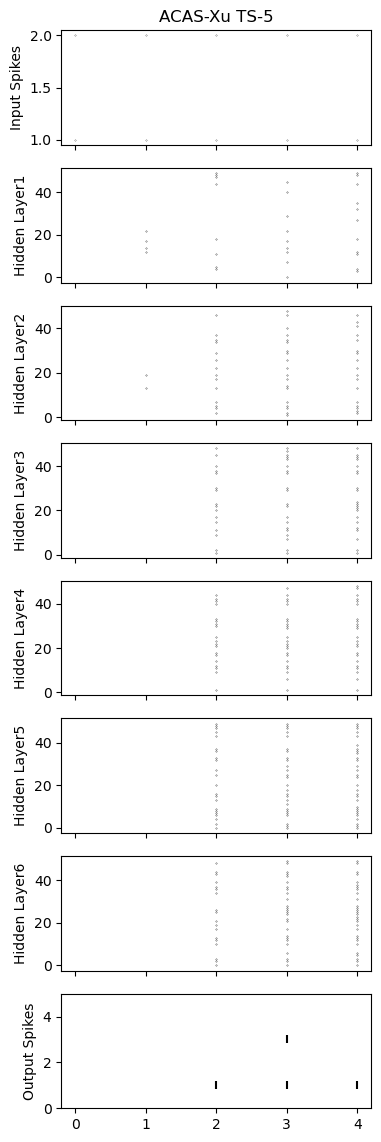

In [38]:
plot_snn_spikes(x, spk_1,spk_2, spk_3,spk_4,spk_5,spk_6, spk_7, "ACAS-Xu TS-5")

# With Encoding (can take different inputs at diffferent time steps)

In [39]:
# spikegen.rate(a, num_steps=1)

In [40]:
inp_ten = torch.tensor([[[1., 0., 1., 0., 1.]],
                        [[1., 0., 1., 0., 1.]],
                        [[0., 0., 0., 0., 0.]],
                        [[0., 0., 0., 0., 0.]],
                        [[0., 0., 0., 0., 0.]]])

In [41]:
inp_ten

tensor([[[1., 0., 1., 0., 1.]],

        [[1., 0., 1., 0., 1.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]]])

In [42]:
spk_7, mem,spk_1,spk_2, spk_3,spk_4,spk_5,spk_6=net(inp_ten)

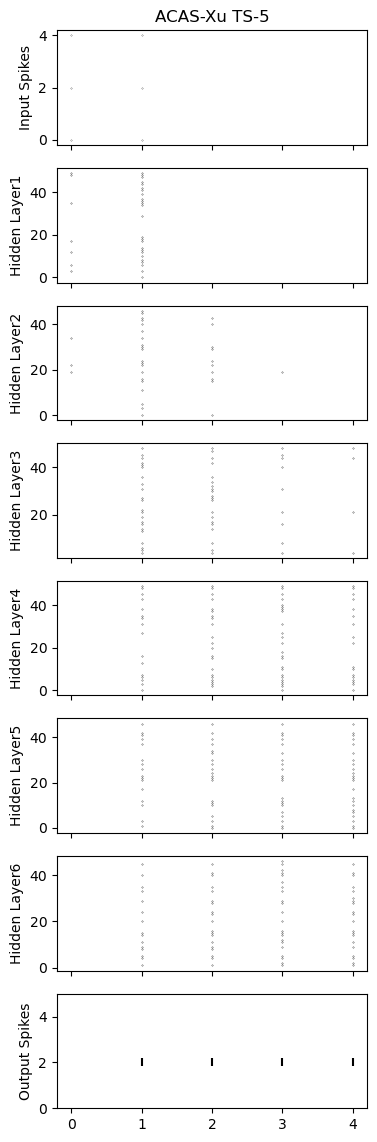

In [43]:
plot_snn_spikes(inp_ten, spk_1,spk_2, spk_3,spk_4,spk_5,spk_6, spk_7, "ACAS-Xu TS-5")

In [44]:
neurons_spiking_in_pytorch(inp_ten)

Neurons spiking in PyTorch simulation:
['X1_1', 'X1_4', 'X1_7', 'X1_8', 'X1_9', 'X1_11', 'X1_13', 'X1_14', 'X1_15', 'X1_18', 'X1_19', 'X1_20', 'X1_30', 'X1_35', 'X1_36', 'X1_37', 'X1_38', 'X1_40', 'X1_42', 'X1_43', 'X1_45', 'X1_46', 'X1_48', 'X1_49', 'X1_50', 'X2_1', 'X2_4', 'X2_6', 'X2_12', 'X2_16', 'X2_17', 'X2_20', 'X2_23', 'X2_24', 'X2_25', 'X2_30', 'X2_31', 'X2_32', 'X2_35', 'X2_38', 'X2_41', 'X2_43', 'X2_44', 'X2_46', 'X2_47', 'X3_5', 'X3_6', 'X3_7', 'X3_9', 'X3_14', 'X3_15', 'X3_17', 'X3_18', 'X3_20', 'X3_22', 'X3_23', 'X3_27', 'X3_28', 'X3_29', 'X3_31', 'X3_32', 'X3_33', 'X3_34', 'X3_35', 'X3_37', 'X3_41', 'X3_42', 'X3_43', 'X3_45', 'X3_46', 'X3_48', 'X3_49', 'X4_1', 'X4_3', 'X4_4', 'X4_5', 'X4_6', 'X4_7', 'X4_8', 'X4_11', 'X4_12', 'X4_14', 'X4_16', 'X4_17', 'X4_19', 'X4_21', 'X4_23', 'X4_26', 'X4_28', 'X4_32', 'X4_35', 'X4_36', 'X4_38', 'X4_39', 'X4_40', 'X4_41', 'X4_44', 'X4_46', 'X4_49', 'X4_50', 'X5_1', 'X5_2', 'X5_4', 'X5_6', 'X5_8', 'X5_9', 'X5_11', 'X5_12', 'X5_13', 'X5_

In [45]:
mem

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-0.3961, -1.0387,  1.7587, -0.6344,  0.1655]],

        [[-1.2017, -2.2551,  2.4476, -1.2637,  0.5939]],

        [[-1.4575, -3.0038,  2.4280, -2.0351,  0.6605]],

        [[-2.0691, -4.1314,  2.5869, -2.4334,  0.8317]]],
       grad_fn=<StackBackward0>)

## ---------------------------------------------- End of code-----------------------------------------------------------------

In [46]:
spk_1

tensor([[[0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]],

        [[1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
          1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [47]:
col_sum1 = torch.sum(spk_1, dim=0)

In [48]:
spikes_1 = torch.nonzero(col_sum1[0] >= 1).flatten()


In [49]:
col_sum1

tensor([[1., 0., 0., 2., 0., 0., 2., 1., 1., 0., 1., 0., 2., 1., 1., 0., 0., 2.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
         1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 2., 2.]],
       grad_fn=<SumBackward1>)

In [50]:
spikes_1

tensor([ 0,  3,  6,  7,  8, 10, 12, 13, 14, 17, 18, 19, 29, 34, 35, 36, 37, 39,
        41, 42, 44, 45, 47, 48, 49])

In [51]:
for s in spikes

SyntaxError: expected ':' (1423690985.py, line 1)